# Three Trading Strategies have been implemented in the pairs trading

1) Z-Score based Strategy

2) Z-Score based Strategy (With Stop-loss and Take-Profit)

3) Moving Average Crossover Strategy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_parquet('data.parquet')

In [4]:
data.head()

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27


In [5]:
data.isnull().sum()

banknifty    1500
nifty        2000
tte             0
dtype: int64

In [6]:
data = data.bfill()

In [7]:
data = data.resample('15T').mean()

In [8]:
# Defining Spread
data['Spread'] = data['banknifty'] - data['nifty']

# Co-integration

In [9]:
data['banknifty'] = data['banknifty'].replace([np.inf, -np.inf], np.nan)
data['nifty'] = data['nifty'].replace([np.inf, -np.inf], np.nan)

# Drop rows with 'NaN' values in either column
data = data.dropna(subset=['banknifty', 'nifty'])

# Check the length of the data after cleaning
print(f"Length of BankNifty IV after cleaning: {len(data['banknifty'])}")
print(f"Length of Nifty IV after cleaning: {len(data['nifty'])}")

# Perform the cointegration test
coint_test = sm.tsa.stattools.coint(data['banknifty'], data['nifty'])

# Output results
print(f"Cointegration test statistic: {coint_test[0]}")
print(f"P-value: {coint_test[1]}")
print(f"Critical values at 1%, 5%, and 10% levels: {coint_test[2]}")

# Interpretation
if coint_test[1] < 0.05:
    print("The time series are likely cointegrated.")
else:
    print("The time series are not likely cointegrated.")

Length of BankNifty IV after cleaning: 46036
Length of Nifty IV after cleaning: 46036
Cointegration test statistic: -4.651546568464766
P-value: 0.0006827635999184768
Critical values at 1%, 5%, and 10% levels: [-3.89667792 -3.33626273 -3.04454213]
The time series are likely cointegrated.


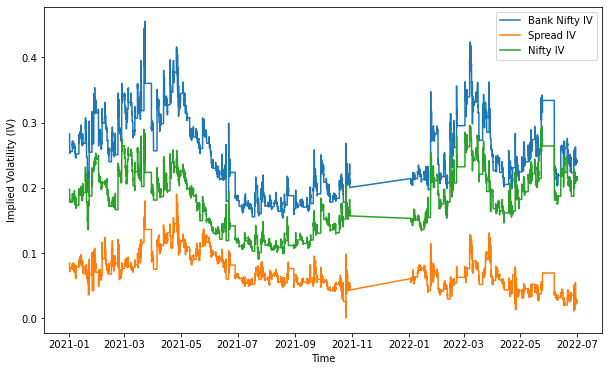

In [10]:
# Ensure the column names match exactly with your DataFrame's columns
banknifty_iv = data['banknifty'].to_numpy()  # Convert the column to a numpy array
nifty_iv = data['nifty'].to_numpy()  # Convert the column to a numpy array
spread_iv =- (data['nifty'].to_numpy() - data['banknifty'].to_numpy())  # Convert the column to a numpy array
dates = data.index.to_numpy()  # Ensure the index is in a proper format

plt.figure(figsize=(10, 6))
plt.plot(dates, banknifty_iv, label='Bank Nifty IV')
plt.plot(dates, spread_iv, label='Spread IV')
plt.plot(dates, nifty_iv, label='Nifty IV')
plt.xlabel('Time')
plt.ylabel('Implied Volatility (IV)')
plt.legend()
plt.show()

# Z-Score Based Trading Strategy (Without Stop-loss)

In [11]:
window_size = 30  # Lookback period for calculating the moving average and standard deviation
data['Spread MA'] = data['Spread'].rolling(window=window_size).mean()
data['Spread Std'] = data['Spread'].rolling(window=window_size).std()

# Calculate the Z-score of the IV spread
data['Z-Score'] = (data['Spread'] - data['Spread MA']) / data['Spread Std']

In [12]:
data['Z-Score'].describe()

count    16268.000000
mean        -0.033349
std          1.546481
min         -5.294651
25%         -0.876265
50%         -0.182574
75%          0.768077
max          5.294651
Name: Z-Score, dtype: float64

Defining Signal

In [13]:
signal_entry = (1.5*data['Z-Score'].std()+data['Z-Score'].mean()) # 1.5times std 
signal_exit = 0

In [14]:
zscore = data['Z-Score']

In [15]:
btest = pd.DataFrame ()
btest["banknifty"] = data[ "banknifty"]
btest["nifty"] = data["nifty"]
btest["short signal"] = (zscore > signal_entry) & (zscore.shift(1) < signal_entry)
btest["short exit"] = (zscore < signal_exit) & (zscore.shift(1) > signal_exit)
btest["long signal"] = (zscore < -signal_entry) & (zscore.shift(1) > -signal_entry)
btest["long exit"] = (zscore > -signal_exit) & (zscore.shift(1) < -signal_exit)

In [16]:
btest

,banknifty,nifty,short signal,short exit,long signal,long exit
time,,,,,,
2021-01-01 09:15:00,0.282703,0.197694,False,False,False,False
2021-01-01 09:30:00,0.274553,0.194369,False,False,False,False
2021-01-01 09:45:00,0.270589,0.192737,False,False,False,False
2021-01-01 10:00:00,0.266847,0.189861,False,False,False,False
2021-01-01 10:15:00,0.268316,0.189841,False,False,False,False
...,...,...,...,...,...,...
2022-06-30 14:30:00,0.239204,0.213454,False,False,False,False
2022-06-30 14:45:00,0.239390,0.212878,False,False,False,False
2022-06-30 15:00:00,0.238744,0.211774,False,False,False,True


getting signals

In [17]:
spread_side = None; counter = -1
backtest_result = []; indicator = 0

for time, signals_stock in btest.iterrows():
    counter+=1
    stock2_, stock1_, short_signal, short_exit, long_signal, long_exit = signals_stock
    
    if spread_side == None:
        backtest_result. append([time, spread_side])
        
        if short_signal == True:
            spread_side = "short"
        elif long_signal == True:
            spread_side = "long"
        
    elif spread_side == "long":
        backtest_result.append([time, spread_side])
        
        if long_exit == True:
            spread_side = None
            
    elif spread_side == "short":
        backtest_result.append([time, spread_side])
                                                         
        if short_exit == True:
            spread_side = None

In [18]:
backtest_pandas = pd.DataFrame(backtest_result)
backtest_pandas.columns = ["Date", "Side"]
backtest_pandas['Spread'] = data['Spread'].values
backtest_pandas['tte'] = data['tte'].values

Calculating the pnl

In [19]:
def calculated_pnl(dataframe):
    realized_pnl = 0
    unrealized_pnl = 0
    position_open = False
    opening_spread = 0
    opening_tte = 0
    current_side = None
    daily_realized_pnl = []
    daily_unrealized_pnl = []

    for _, row in dataframe.iterrows():
        # Calculate unrealized PnL
        if position_open:
            if current_side == 'long':
                unrealized_pnl = (row['Spread'] * (row['tte'] ** 0.7) - opening_spread * (opening_tte ** 0.7))
            elif current_side == 'short':
                unrealized_pnl = (opening_spread * (opening_tte ** 0.7) - row['Spread'] * (row['tte'] ** 0.7))

        # Check for side change (from long to short or short to long) to realize PnL
        if row['Side'] != None and position_open and row['Side'] != current_side:
            # Realize the PnL when the side changes
            realized_pnl += unrealized_pnl
            unrealized_pnl = 0  # Reset unrealized PnL

        # Open or change position
        if row['Side'] != None and (not position_open or row['Side'] != current_side):
            position_open = True
            current_side = row['Side']
            opening_spread = row['Spread']
            opening_tte = row['tte']

        daily_realized_pnl.append(realized_pnl)
        daily_unrealized_pnl.append(unrealized_pnl)

    dataframe['Daily Realized PnL'] = daily_realized_pnl
    dataframe['Daily Unrealized PnL'] = daily_unrealized_pnl
    dataframe['Daily Total PnL'] = [r + u for r, u in zip(daily_realized_pnl, daily_unrealized_pnl)]

    return dataframe, realized_pnl, unrealized_pnl


In [20]:
df, unrealised_pnl, realised_pnl = calculated_pnl(backtest_pandas)

<Figure size 1080x432 with 0 Axes>

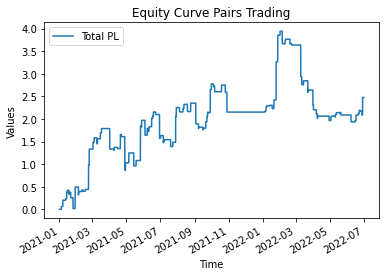

In [21]:
backtest_pandas["Total PL"] = df['Daily Realized PnL']
backtest_pandas.index = backtest_pandas["Date"]

plt.figure(figsize=(15, 6))
backtest_pandas[["Total PL"]].plot(label = "Evolution Profit and Loss")
plt.title("Equity Curve Pairs Trading")
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [22]:
df = df.dropna(subset=['Daily Realized PnL'])

# Calculate daily returns
df['Daily Return'] = df['Daily Realized PnL'].pct_change()

# Drop any NaN created by the pct_change method
df = df.dropna(subset=['Daily Return'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Ensure there is more than one unique return value to avoid division by zero in standard deviation
if df['Daily Return'].nunique() > 1:
    average_daily_return = df['Daily Return'].mean()
    std_dev_daily_return = df['Daily Return'].std()

    # Assuming the risk-free rate is close to 0% (adjust if you have a specific rate)
    risk_free_rate = 0.0
    annual_factor = 252*25  # Adjust based on your data's frequency

    # Calculate the Sharpe Ratio (annualized)
    sharpe_ratio = ((average_daily_return - risk_free_rate) / std_dev_daily_return) * np.sqrt(annual_factor)
    print(f"Sharpe Ratio: {sharpe_ratio}")
else:
    print("Insufficient variation in daily returns to calculate Sharpe Ratio.")

Sharpe Ratio: 0.4596282136037853


In [23]:
# Calculate the running maximum
running_max = df['Daily Realized PnL'].cummax()

# Calculate the drawdown
drawdown = (df['Daily Realized PnL'] - running_max) / running_max

# Find the maximum drawdown (indexOf minimum drawdown)
max_drawdown_index = drawdown.idxmin()

# Access the drawdown value at the index of minimum drawdown
max_drawdown = drawdown.loc[max_drawdown_index]

In [24]:
# Display the minimum and maximum values of the Daily Realized PnL column
min_pnl = df['Daily Realized PnL'].min()
max_pnl = df['Daily Realized PnL'].max()
print(f"Minimum Daily Realized PnL: {min_pnl}")
print(f"Maximum Daily Realized PnL: {max_pnl}")

# Display the data type of the Daily Realized PnL column
pnl_dtype = df['Daily Realized PnL'].dtype
print(f"Data type of Daily Realized PnL: {pnl_dtype}")

Minimum Daily Realized PnL: 0.017461564679099373
Maximum Daily Realized PnL: 3.9395216091404888
Data type of Daily Realized PnL: float64


In [25]:
print(f"Drawdown(%): {abs(max_drawdown)}")

Drawdown(%): 0.9585018907408429


# Z-Score Based Trading Strategy (with Stop-loss)

In [26]:
def calculate_pnl(dataframe, stop_loss_percent=0.2, risk_reward_ratio=2):
    realized_pnl = 0
    unrealized_pnl = 0
    position_open = False
    opening_spread = 0
    opening_tte = 0
    current_side = None
    daily_realized_pnl = []
    daily_unrealized_pnl = []

    for _, row in dataframe.iterrows():
        if position_open:
            if current_side == 'long':
                unrealized_pnl = (row['Spread'] * (row['tte'] ** 0.7) - opening_spread * (opening_tte ** 0.7))
            elif current_side == 'short':
                unrealized_pnl = (opening_spread * (opening_tte ** 0.7) - row['Spread'] * (row['tte'] ** 0.7))

            # Check for stop loss or take profit
            if current_side == 'long':
                loss = (opening_spread * (opening_tte ** 0.7) - row['Spread'] * (row['tte'] ** 0.7))
                profit_target = opening_spread * (opening_tte ** 0.7) + 2 * loss * risk_reward_ratio
                if loss >= opening_spread * stop_loss_percent or row['Spread'] * (row['tte'] ** 0.7) >= profit_target:
                    realized_pnl += unrealized_pnl
                    position_open = False
                    unrealized_pnl = 0

            elif current_side == 'short':
                loss = (row['Spread'] * (row['tte'] ** 0.7) - opening_spread * (opening_tte ** 0.7))
                profit_target = opening_spread * (opening_tte ** 0.7) - 2 * loss * risk_reward_ratio
                if loss >= opening_spread * stop_loss_percent or row['Spread'] * (row['tte'] ** 0.7) <= profit_target:
                    realized_pnl += unrealized_pnl
                    position_open = False
                    unrealized_pnl = 0

        if row['Side'] != None and (not position_open or row['Side'] != current_side):
            position_open = True
            current_side = row['Side']
            opening_spread = row['Spread']
            opening_tte = row['tte']

        daily_realized_pnl.append(realized_pnl)
        daily_unrealized_pnl.append(unrealized_pnl)

    dataframe['Daily Realized PnL'] = daily_realized_pnl
    dataframe['Daily Unrealized PnL'] = daily_unrealized_pnl
    dataframe['Daily Total PnL'] = [r + u for r, u in zip(daily_realized_pnl, daily_unrealized_pnl)]

    return dataframe, realized_pnl, unrealized_pnl

In [27]:
df, unrealised_pnl, realised_pnl = calculate_pnl(backtest_pandas)

<Figure size 1080x432 with 0 Axes>

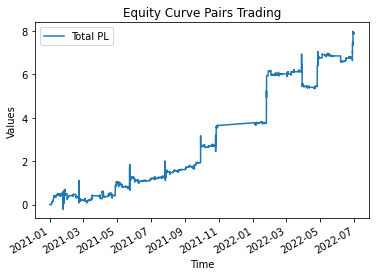

In [28]:
backtest_pandas["Total PL"] = df['Daily Realized PnL']
backtest_pandas.index = backtest_pandas["Date"]

plt.figure(figsize=(15, 6))
backtest_pandas[["Total PL"]].plot(label = "Evolution Profit and Loss")
plt.title("Equity Curve Pairs Trading")
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [29]:
df = df.dropna(subset=['Daily Realized PnL'])

# Calculate daily returns
df['Daily Return'] = df['Daily Realized PnL'].pct_change()

# Drop any NaN created by the pct_change method
df = df.dropna(subset=['Daily Return'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Ensure there is more than one unique return value to avoid division by zero in standard deviation
if df['Daily Return'].nunique() > 1:
    average_daily_return = df['Daily Return'].mean()
    std_dev_daily_return = df['Daily Return'].std()

    # Assuming the risk-free rate is close to 0% (adjust if you have a specific rate)
    risk_free_rate = 0.0
    annual_factor = 252*25  # Adjust based on your data's frequency

    # Calculate the Sharpe Ratio (annualized)
    sharpe_ratio = ((average_daily_return - risk_free_rate) / std_dev_daily_return) * np.sqrt(annual_factor)
    print(f"Sharpe Ratio: {sharpe_ratio}")
else:
    print("Insufficient variation in daily returns to calculate Sharpe Ratio.")


Sharpe Ratio: 0.8764127844424192


In [30]:
# Calculate the running maximum
running_max = df['Daily Realized PnL'].cummax()

# Calculate the drawdown
drawdown = (df['Daily Realized PnL'] - running_max) / running_max

# Find the maximum drawdown (indexOf minimum drawdown)
max_drawdown_index = drawdown.idxmin()

# Access the drawdown value at the index of minimum drawdown
max_drawdown = drawdown.loc[max_drawdown_index]

In [31]:
# Display the minimum and maximum values of the Daily Realized PnL column
min_pnl = df['Daily Realized PnL'].min()
max_pnl = df['Daily Realized PnL'].max()
print(f"Minimum Daily Realized PnL: {min_pnl}")
print(f"Maximum Daily Realized PnL: {max_pnl}")

# Display the data type of the Daily Realized PnL column
pnl_dtype = df['Daily Realized PnL'].dtype
print(f"Data type of Daily Realized PnL: {pnl_dtype}")

Minimum Daily Realized PnL: -0.2170027290440334
Maximum Daily Realized PnL: 7.993592165255563
Data type of Daily Realized PnL: float64


In [32]:
print(f"Drawdown(%): {abs(max_drawdown)}")

Drawdown(%): 1.3589401396699448


# Moving Average Crossover Strategy

In [45]:
# Calculate SMA and EMA
window_short = 20  # Short window for EMA and SMA
window_long = 30   # Long window for EMA and SMA

data['ema_short'] = data['Spread'].ewm(span=window_short, adjust=False).mean()
data['ema_long'] = data['Spread'].ewm(span=window_long, adjust=False).mean()

data['sma_short'] = data['Spread'].rolling(window=window_short).mean()
data['sma_long'] = data['Spread'].rolling(window=window_long).mean()

# Define entry and exit signals based on SMA and EMA
data['long_signal'] = data['ema_short'] > data['ema_long']  # EMA short > EMA long
data['long_exit'] = data['ema_short'] < data['ema_long']    # EMA short < EMA long

data['short_signal'] = data['sma_short'] < data['sma_long']  # SMA short < SMA long
data['short_exit'] = data['sma_short'] > data['sma_long']    # SMA short > SMA long

# Short Stocks
btest = pd.DataFrame()
btest["banknifty"] = data["banknifty"]
btest["nifty"] = data["nifty"]
btest["long_signal"] = data['long_signal']
btest["long_exit"] = data['long_exit']
btest["short_signal"] = data['short_signal']
btest["short_exit"] = data['short_exit']

spread_side = None
counter = -1
backtest_result = []
stop_loss_percentage = 0.2  # Stop loss as 1%
risk_reward_ratio = 2  # Risk to reward ratio 1:2

for time, signals_stock in btest.iterrows():
    counter += 1
    stock2_, stock1_, long_signal, long_exit, short_signal, short_exit = signals_stock

    if spread_side is None:
        backtest_result.append([time, spread_side])

        if long_signal:
            spread_side = "long"
            entry_price = data.at[time, 'Spread']
            take_profit = entry_price + (entry_price * stop_loss_percentage * risk_reward_ratio)
            stop_loss = entry_price - (entry_price * stop_loss_percentage)
        elif short_signal:
            spread_side = "short"
            entry_price = data.at[time, 'Spread']
            take_profit = entry_price - (entry_price * stop_loss_percentage * risk_reward_ratio)
            stop_loss = entry_price + (entry_price * stop_loss_percentage)

    elif spread_side == "long":
        backtest_result.append([time, spread_side])

        if data.at[time, 'Spread'] <= stop_loss or data.at[time, 'Spread'] >= take_profit or long_exit:
            spread_side = None

    elif spread_side == "short":
        backtest_result.append([time, spread_side])

        if data.at[time, 'Spread'] >= stop_loss or data.at[time, 'Spread'] <= take_profit or short_exit:
            spread_side = None

backtest_pandas = pd.DataFrame(backtest_result)
backtest_pandas.columns = ["Date", "Side"]
backtest_pandas['Spread'] = data['Spread'].values
backtest_pandas['tte'] = data['tte'].values

df, unrealized_pnl, realized_pnl = calculate_pnl(backtest_pandas)
df = df.dropna(subset=['Daily Realized PnL'])

# Calculate daily returns
df['Daily Return'] = df['Daily Realized PnL'].pct_change()

# Drop any NaN created by the pct_change method
df = df.dropna(subset=['Daily Return'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Ensure there is more than one unique return value to avoid division by zero in standard deviation
if df['Daily Return'].nunique() > 1:
    average_daily_return = df['Daily Return'].mean()
    std_dev_daily_return = df['Daily Return'].std()

    # Assuming the risk-free rate is close to 0% (adjust if you have a specific rate)
    risk_free_rate = 0.0
    annual_factor = 252 * 25  # Adjust based on your data's frequency

    # Calculate the Sharpe Ratio (annualized)
    sharpe_ratio = ((average_daily_return - risk_free_rate) / std_dev_daily_return) * np.sqrt(annual_factor)
    print(f"Sharpe Ratio: {sharpe_ratio}")
else:
    print("Insufficient variation in daily returns to calculate Sharpe Ratio.")


Sharpe Ratio: 0.5857776967507844
